In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, TimeDistributed, Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import matplotlib.mlab as mlab
import seaborn as sns  
from numpy import genfromtxt

In [3]:
input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snrminusfifteen_final.csv'
my_data_flipped = genfromtxt(input_file, delimiter=',')

In [4]:
new_data = np.delete(my_data_flipped, (0), axis=0)

In [5]:
X2 = np.delete(new_data, (0,32), axis=1)

In [6]:
Y2 = new_data[:,32]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [8]:
X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

# Build LSTM Network

In [9]:
num_neurons = 31
num_features = 31


model = Sequential()
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 31)             7812      
_________________________________________________________________
lstm_1 (LSTM)                (None, 31)                7812      
_________________________________________________________________
dense (Dense)                (None, 1)                 32        
Total params: 15,656
Trainable params: 15,656
Non-trainable params: 0
_________________________________________________________________
inputs:  (None, 1, 31)
outputs:  (None, 1)
actual inputs:  (225000, 1, 31)
actual outputs:  (225000,)


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
print('Training LSTM...')

batch_size = 5

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

Training LSTM...
Train on 225000 samples, validate on 75000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
225000/225000 [==============================] - 192s 855us/sample - loss: 0.6375 - acc: 0.6663 - val_loss: 0.6358 - val_acc: 0.6675
Epoch 2/5
225000/225000 [==============================] - 188s 835us/sample - loss: 0.6365 - acc: 0.6664 - val_loss: 0.6359 - val_acc: 0.6675
Epoch 3/5
225000/225000 [==============================] - 189s 840us/sample - loss: 0.6358 - acc: 0.6664 - val_loss: 0.6356 - val_acc: 0.6675
Epoch 4/5
225000/225000 [==============================] - 183s 812us/sample - loss: 0.6352 - acc: 0.6664 - val_loss: 0.6359 - val_acc: 0.6675
Epoch 5/5
75000/75000 [==============================] - 16s 214us/sample - loss: 0.6359 - acc: 0.6675 - loss: 0.636


In [13]:
print('score:', score)
print('accuracy:', acc)

score: 0.6358702199697495
accuracy: 0.66752


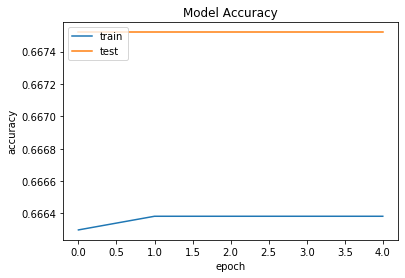

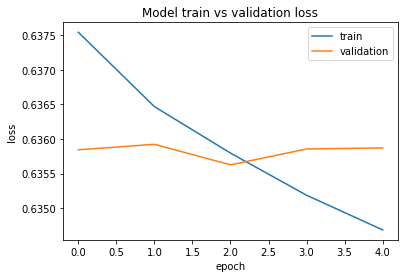

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
# Let's save the model to disc
json = model.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/AWGN_Models/model_one_snrminusfifteen.json", "w") as file:
    file.write(json)
model.save_weights("/Users/niall/Documents/Cypress_Code/Models/AWGN_Models/model_one_snrminusfifteen.h5")
print("Saved model to disc")

Saved model to disc


In [16]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/AWGN_Models/model_one_snrminusfifteen.json', 'r')
json = json_file.read()
json_file.close()
model_one_from_disc = model_from_json(json)
model_one_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/AWGN_Models/model_one_snrminusfifteen.h5")

In [17]:
y_pred_from_disk = model_one_from_disc.predict(X_test, batch_size=1, verbose=1)

75000/75000 [==============================] - 66s 881us/sample


In [18]:
pred = pd.DataFrame(y_pred_from_disk, columns =['Y_pred']) 
pred['Label'] = y_test

In [19]:
pred.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/AWGN/model_one_snrminusfifteen.csv', index = False)